In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib
import random 
from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
plot_distributions = False
for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        
        if plot_distributions:
            distvals = np.array(sorted(list(dist.values()), reverse=True))
            distvals = distvals/distvals.sum()
            plt.figure()
            sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
            plt.title('Density over different edits for guide {0}'.format(guide))
            plt.show()
            plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]





Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


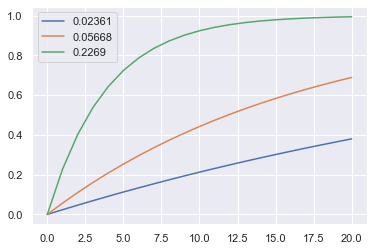

In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""

plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [4]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 1000
num_arrays = 10

init_cell_list = [1, 5, 10, 50, 100]
death_rep_probs = [(0.1, 0.75), (0.2, 0.75), (0.1,0.9)]
cancer_probs = [1e-3, 1e-2]
missing_fracs = [0.2, 0.1, 0.05, 0.01, 0]

debug = True
compute_tree = False

if debug:
    lists_of_guides = [fast_guides]
    labels = ['smf']
    tree_depth = 20
    num_runs = 1
    n_subsample = 500
    num_arrays = 10
    init_cell_list = [1]
    
    death_rep_probs = [(0.1, 0.75)]
    cancer_probs = [1e-3]
    
    missing_fracs = [0.01]

Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
drop 150 (500, 30)


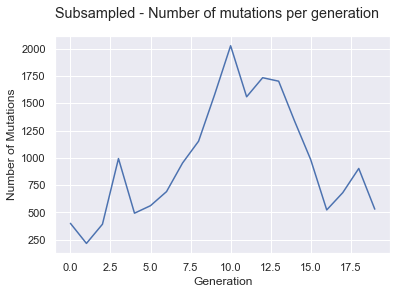

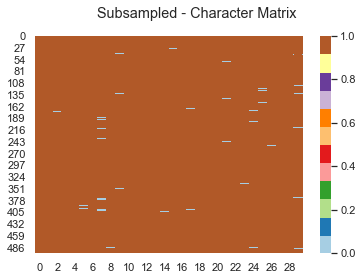

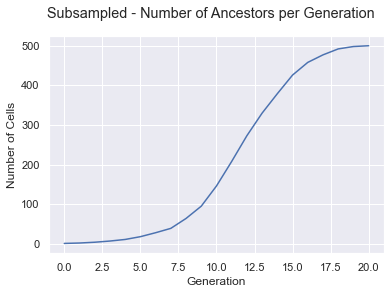

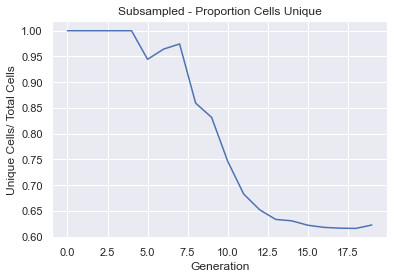

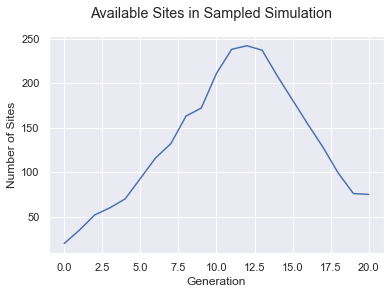

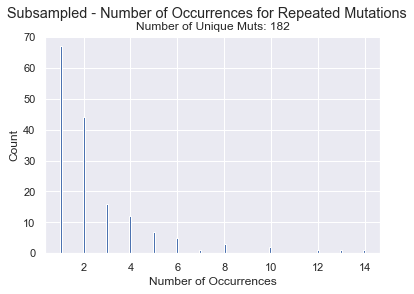

Reconstructing greedy tree
Getting tree with missing data.


In [ ]:
import crispr_lib
importlib.reload(crispr_lib)

simulation_list = []


missing_results = {'params':[('death_prob', 'rep_prob','cancer_prob','guide','init_cells','run','missing_frac')], 
           'outcomes':[('greedy_tree', 'scores', 'cass_tree', 'cass_scores', 'simulation')]}

for missing_frac in missing_fracs:
    for init_death_prob, init_repr_prob in death_rep_probs:
        for cancer_prob in cancer_probs:
            for i, list_of_guides in enumerate(lists_of_guides):
                label = labels[i]
                print('Label:', label)

                # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
                site_ix = 0
                target_distributions = {}
                speed = {}
                for guide in list_of_guides:
                    dist = indel_distributions[guide]
                    try:
                        del dist['']
                    except KeyError:
                        pass
                    distvals = np.array(sorted(list(dist.values()), reverse=True))
                    distvals = distvals/distvals.sum()
                    target_distributions[site_ix] = distvals
                    if guide in slow_guides:
                        speed[site_ix] = 'slow'
                    elif guide in medium_guides:
                        speed[site_ix] = 'medium'
                    else:
                        speed[site_ix] = 'fast'

                    site_ix += 1

                num_targets = site_ix 
                num_edit_sites = num_targets * num_arrays

                import itertools
                targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
                print('List of targets: ', targets)

                deletions = []
                mutation_probs = []
                for array, target in targets:
                    deletions.append(target_distributions[target])
                    mutation_probs.append(rate[speed[target]])

                deletions_probs = pd.DataFrame(deletions)
                deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)

                # Each edit site has a different mutation probability 
                mutation_probs= np.array(mutation_probs)

                deletions_probs = deletions_probs[:, :100]
                deletions_probs /= deletions_probs.sum(1, keepdims=True)

                edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])



                for init_cells in init_cell_list:

                    for run in range(num_runs):

                        try:
                            try:
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction= missing_frac,
                                                                         identify_recurrent_muts=False)
                            except:
                                # If simulation fails, try again to generate sufficient cells
                                simulation = crispr_lib.lineageSimulationImbalanced(label, tree_depth, 
                                                                         num_edit_sites, deletions_probs, 
                                                                         mutation_probs, edit_probs, 
                                                                         init_cells=init_cells, 
                                                                         n_subsample=n_subsample,
                                                                         missing_fraction=missing_frac, 
                                                                         identify_recurrent_muts=False)


                            simulation_list.append(simulation)

                            ## Benchmark reconstruction performance on this simulation (Cassiopeia vs Greedy + NJ)
                            from greedy_reconstruct import greedy_probabilistic
                            # Compute reconstruction accuracy from greedy + reassignment method
                            greedy_tree, scores = greedy_probabilistic(simulation,
                                                           impute_missing_data=False,
                                                           max_cells_per_greedy_node = 50)

                            from cass_helper import cassiopeia_reconstruct

                            from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
                            from cassiopeia.TreeSolver.score_triplets import score_triplets
                            from cassiopeia.TreeSolver.Node import Node 
                            from cassiopeia.TreeSolver.lineage_solver.lineage_solver import solve_lineage_instance

                            # Compute Cassiopeia reconstruction accuracy
                            cass_tree, cass_scores = cassiopeia_reconstruct(simulation)
                            
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((greedy_tree, scores, cass_tree, cass_scores, simulation))
                            
                        except Exception as e:
                            print(e)
                            missing_results['params'].append((init_death_prob, init_repr_prob, cancer_prob, label, init_cells, run, missing_frac))
                            missing_results['outcomes'].append((e, simulation))

## Tree Reconstructions 

Compare various methods of tree reconstruction to determine which has the best performance

In [ ]:
import greedy_reconstruct
importlib.reload(greedy_reconstruct)

greedy_tree, scores = greedy_reconstruct.greedy_probabilistic(simulation,
                                           impute_missing_data=False,
                                           max_cells_per_greedy_node = 50)

In [ ]:
simulation = simulation_list[0]

impute_missing_data = False
print('Reconstructing greedy tree')
if impute_missing_data:
    simulation.imputation_on()
else:
    simulation.imputation_off()

true_tree = simulation.get_cleaned_tree()

print('Got true_tree')
character_matrix = simulation.get_final_cells()
character_matrix.drop_duplicates()
RAND_MAX = 100000 #HACKY

max_cells_per_greedy_node = 50

character_matrix = character_matrix.drop_duplicates()
character_matrix.index = utilities.character_matrix_to_labels(character_matrix)

# Convert character matrix to binary feature matrix for neighbour joining 
feature_matrix = utilities.binarize_character_matrix(character_matrix)

dels_probs = simulation.get_edit_probs()
prob_features = dels_probs[feature_matrix.columns].values


# Split by most frequently occuring character until cell groups are small enough to do neighbour joining efficiently. 
def recursive_split(fm, cm):
    if fm.shape[0] <= max_cells_per_greedy_node:

        # Create a node containing all the cells in this subtree
        leaf = CellGroupNode(f'lf-{np.random.randint(RAND_MAX)}') 
        leaf.add_feature_matrix(fm)
        leaf.add_character_matrix(cm)
        return leaf

    # Determine the mutation which appears in the largest number of cells (but not all the cells) 
    proportion = fm.sum(axis=0)/fm.shape[0]
    proportion[proportion==1] = 0

    split_on = fm.columns[np.argmax(proportion)]


    left_child = fm[fm[split_on]==1]
    right_child = fm[fm[split_on]!=1]

    if len(left_child)==0 or len(right_child)==0:
        # Return here, no further splitting is possible
        leaf = CellGroupNode(f'lf-{np.random.randint(RAND_MAX)}') 
        leaf.add_feature_matrix(fm)
        leaf.add_character_matrix(cm)

        return leaf

    left_cm = cm.loc[left_child.index]
    right_cm = cm.loc[right_child.index]

    node = CellGroupNode(f'hdn-{np.random.randint(RAND_MAX)}')

    left_child = recursive_split(left_child, left_cm)        
    left_child.add_defining_muts((split_on, 1))

    right_child = recursive_split(right_child, right_cm)
    right_child.add_defining_muts((split_on, 0))
    left_child.parent = node
    right_child.parent = node 

    node.children = [left_child, right_child]
    return node  

greedy_tree = recursive_split(feature_matrix, character_matrix)

# Perform probabilistic re-assignment of leaves 
# For each leaf node, determine the profile of mutations that characterize the tip.

# Option 1: TODO: Use all the defining mutations accumulated along this lineage
# Option 2: Use the consensus over all cells 


star_tree = greedy_tree.copy()

if greedy_tree.is_tip():
    print('Greedy tree contains only one cell. No need to reassign cells.')
    reassign = False
    leaves = [star_tree]


print('Computing before')
muts_in_leaf = []
leaves = [x for x in star_tree.tips()]
for i, leaf in enumerate(leaves):
    # Determine consensus of leaf, aka which mutations are present in all cells in the group.
    consensus_muts = (leaf.feature_matrix.sum(0)/leaf.feature_matrix.shape[0]) == 1
    consensus_muts = consensus_muts.astype(int).values
    muts_in_leaf.append(consensus_muts)

scores = {}
# Compute triplets correct before reassignment

for leaf in leaves:
    # Create a star tree for the unresolved cells at the tips
    for name in leaf.char_matrix.index:
        print(name, leaf.char_matrix.loc[name])
        node = CellGroupNode(str(name), parent=leaf)
        node.add_character_matrix(pd.DataFrame(leaf.char_matrix.loc[name]).T)        
        node.add_feature_matrix(leaf.feature_matrix.loc[name])
        leaf.children.append(node)
        
star_tree.condense_duplicate_leaves()
score = utilities.triplets_correct(true_tree, star_tree)
print('Score before reassignment: ', score)
scores['before'] = score

if reassign:
    # Compute the probabilistic assignment of cells to cellgroup leaves
    fm = []
    cm = []
    original_leaf = []

    for i, leaf in enumerate(leaves):
        fm.append(leaf.feature_matrix)
        cm.append(leaf.get_character_matrix())
        original_leaf += [i]*len(fm[-1])
    fm = pd.concat(fm, axis=0)
    cm = pd.concat(cm, axis=0)



    original_leaf = np.array(original_leaf)

    leaf_agreement = np.dot(fm.values, np.vstack(muts_in_leaf).T)
    new_assignments = leaf_agreement.argmax(1)
    changed_assignments = (new_assignments != original_leaf).sum()
    print(f'Reassigned {changed_assignments} leaves out of a total of {len(new_assignments)} leaves.')

    fm['Updated_CellGroup'] = new_assignments
    cm['Updated_CellGroup'] = new_assignments

    # Reallocate the leaf indices of all cells into the original tree structure.
    for i, leaf in enumerate(leaves):
        leaf.add_feature_matrix(fm[fm["Updated_CellGroup"] == i].drop('Updated_CellGroup', axis=1))
        leaf.add_character_matrix(cm[cm["Updated_CellGroup"] == i].drop('Updated_CellGroup', axis=1))

    # If any leaf no longer has any cells, remove from the tree. 
    n_removed = 0
    for i, leaf in enumerate(leaves):
        if len(leaf.feature_matrix) == 0:
            n_removed += 1
            leaf.parent.children.remove(leaf)
            while len(leaf.parent.children) == 0:
                leaf = leaf.parent
                leaf.parent.children.remove(leaf)

    print(f'Removed {n_removed} leaves after reassigning cells.')

    # Compute the triplets correct after reassigning cells
    star_tree = greedy_tree.copy()
    for leaf in star_tree.tips():
        if leaf.name[:3] == 'hdn':
            # Internal nodes should node be considered since they have no associated cells.
            continue

        # Create a star tree for the unresolved cells at the tips
        for name in leaf.char_matrix.index:
            node = CellGroupNode(str(name), parent=leaf)
            node.add_character_matrix(leaf.char_matrix.loc[name])        
            node.add_feature_matrix(leaf.feature_matrix.loc[name])

            leaf.children.append(node)
    star_tree.condense_duplicate_leaves()
    score = utilities.triplets_correct(true_tree, star_tree)

    print('Score after reassignment: ', score)
    scores['after'] = score

# Finally, perform neighbor joining in each leaf to complete the tree.

leaves = [x for x in greedy_tree.tips()]
if len(leaves) == 0:

    leaf = greedy_tree
    fm = leaf.feature_matrix 
    if len(fm) < 2:
        name=fm.index[0]
        root = CellGroupNode(name)
        root.add_character_matrix(leaf.get_character_matrix().loc[name])
        root.add_feature_matrix(leaf.get_feature_matrix().loc[name])
    else:
        root, steps = mod_nj(fm, leaf.get_character_matrix(), prob_features)
    greedy_tree = root

else:
    for leaf in leaves:
        fm = leaf.feature_matrix 
        if len(fm) < 2:
            name=fm.index[0]
            root = CellGroupNode(name)
            root.add_character_matrix(leaf.get_character_matrix().loc[name])
            root.add_feature_matrix(leaf.get_feature_matrix().loc[name])
        else:
            root, steps = mod_nj(fm, leaf.get_character_matrix(), prob_features)

        root.parent = leaf.parent  
        # Replace leaf with new root 
        leaf.parent.children.remove(leaf)
        leaf.parent.children.append(root)

greedy_tree.condense_duplicate_leaves()
score = utilities.triplets_correct(true_tree, greedy_tree)
print('Score after neighbor joining: ', score)
scores['nj'] = score

In [ ]:
[x.name for x in star_tree.tips()]

In [ ]:
[x.shape for x in leaves]

In [ ]:
import utilities
from modified_nj import mod_nj
from Node import CellGroupNode

In [ ]:
# Summarise results of experiment:

params = results['params']
outcomes = results['outcomes']

print(params[0])
print(outcomes[0])

failed_outcomes = {'params':[], 'outcomes':[]}


summary = {'death_prob':[], 'rep_prob':[], 'cancer_prob':[], 'guide':[], 'init_cells':[], 'run':[],
           'before':[], 'after':[], 'nj':[], 'cassiopeia':[]          } 
for i in range(1, len(params)):
    param = params[i]
    outcome = outcomes[i]
    
    if len(outcome) == 2:
        failed_outcomes['params'].append(param)
        failed_outcomes['outcomes'].append(outcome)
        
        continue
        
    death_prob, rep_prob, cancer_prob, guide, init_cells, run = param
    greedy_tree, scores, cass_tree, cass_scores, simulation = outcome
    
    summary['death_prob'].append(death_prob)
    summary['rep_prob'].append(rep_prob)
    summary['cancer_prob'].append(cancer_prob)
    summary['guide'].append(guide)
    summary['init_cells'].append(init_cells)
    summary['run'].append(run)
    
    summary['before'].append(scores['before'])
    summary['after'].append(scores['after'])
    summary['nj'].append(scores['nj'])
    summary['cassiopeia'].append(cass_scores['our_score'])
    

In [ ]:
failed_outcomes

In [ ]:
summary_df = pd.DataFrame(summary)
summary_df['reassign_delta'] = summary_df['after'] - summary_df['before']
summary_df['nj_delta'] = summary_df['nj'] - summary_df['after']

summary_df.to_csv('summary_of_imbalanced_results_missing_data.csv')


In [ ]:
# def format_char_vec(a):
#     nan_a = np.isnan(a)
#     a = a.astype(np.int).astype(str)
#     a[nan_a] = '-'
#     return list(a)

# for simulation in simulation_list:
#     simulation.random_attr['missing_data_expt'] = {'frac':[],'cass':[],'ours':[],'base_score':[]}
#     for frac in [0.05, 0.1, 0.2]:
#         simulation.random_attr['missing_data_expt']['frac'].append(frac)
        
#         priors = None

#         cell_record = simulation.get_cell_record()
#         # Randomly drop mutations to introduce missingness in data 
#         prop = int(cell_record[-1].size * frac)
#         #Randomly choose indices of the numpy array:
#         i = [random.choice(range(cell_record[-1].shape[0])) for _ in range(prop)]
#         j = [random.choice(range(cell_record[-1].shape[1])) for _ in range(prop)]

#         cell_record[-1][i,j] = np.NaN
        
#         # Modify true network to incorporate missing data 
#         import networkx as nx
#         from cassiopeia.TreeSolver.Node import Node

#         # Create networkx DiGraph to represent true_tree 
#         tree = nx.DiGraph()
        
#         # Create nodes representing the leaves
#         level_ix = simulation.subsampled_ix
#         record = cell_record[-1]
#         tips = [Node(str(i), format_char_vec(record[i])) for i in np.arange(len(level_ix))]
        
        
#         ## FIX THIS 
        
#         raise NotImplementedError
        
#         for j in (range(simulation.tree_depth-1, -1, -1)):
#             # Map the subsampled cells from the preceding level as parents/children
#             parent_ix = level_ix//2
#             parent_dict = {}
#             record = cell_record[j]

#             parent_ix_map = dict(zip(np.unique(parent_ix), np.arange(len(np.unique(parent_ix)))))        

#             for i, ix in enumerate(parent_ix):
#                 # Get record corresponding to parent 
#                 parent = parent_dict.get(ix, Node(str(ix), format_char_vec(record[parent_ix_map[ix]])))
#                 parent_dict[ix] = parent
#                 tree.add_edges_from([(parent, tips[i])])

#             # These are the new base layer, and we continue to build upwards
#             level_ix = pd.unique(parent_ix)
#             tips = [parent_dict[ix] for ix in level_ix]
            
#         true_network = tree 
        
        

#         simulation.random_attr['missing_data_expt']['base_score'].append(base_score)
        
#         t = time.time()
#         reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
#                                                               method="greedy", 
#                                                               prior_probabilities=priors)
#         cass_time = time.time()-t
#         cass_tree = reconstructed_network_greedy[0]
#         cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Cassiopeia Score: ', cass_score)
#         print('Cassiopeia Time: ', cass_time)

#         cass = [cass_tree, cass_score, cass_time]
#         simulation.random_attr['missing_data_expt']['cass'].append(cass)
        

#         t = time.time()
#         new_priors = torch.distributions.Categorical(torch.DoubleTensor(simulation.edit_probs))
#         tree, steps = cluster_nx(character_matrix, new_priors)
#         our_time = time.time()-t


#         our_tree = Cassiopeia_Tree(method ='simulated', network = tree)
#         our_score = score_triplets(true_network, our_tree, number_of_trials = 5000, min_size_depth = 20)
#         print('Our Score:', our_score)
#         print('Our Time: ', our_time)
        
#         ours = [our_tree, our_score, our_time]
#         simulation.random_attr['missing_data_expt']['ours'].append(ours)